In [1]:
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import os
from pyro.nn import PyroModule, PyroSample
from torch import nn
import torch
import pyro.distributions as dist
from chirho.observational.handlers import condition
from chirho.observational.handlers.predictive import PredictiveModel
from chirho.counterfactual.handlers import MultiWorldCounterfactual
from chirho.indexed.ops import IndexSet, gather
from chirho.interventional.handlers import do
from pyro.infer.autoguide import AutoNormal
from pyro.infer import SVI, Trace_ELBO, Predictive
import functools
from chirho.robust.handlers.estimators import MonteCarloInfluenceEstimator, one_step_corrected_estimator 
from typing import Callable
from tqdm import tqdm

torch.set_default_device('cpu')
pyro.settings.set(module_local_params=True)

smoke_test = "CI" in os.environ

# Model definitions

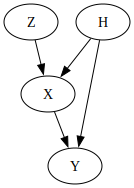

In [2]:
class BayesianLinearGaussianSCM(PyroModule):
    def __init__(self):
        super().__init__()

    @PyroSample
    def alpha(self):
        return dist.Normal(0,10)

    @PyroSample
    def beta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def gamma(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def delta(self):
        return dist.Normal(0, 10)
    
    @PyroSample
    def sigmaZ(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaH(self):
        return dist.Uniform(0,2)
    
    @PyroSample
    def sigmaX(self):
        return dist.Uniform(0,10)
    
    @PyroSample
    def sigmaY(self):
        return dist.Uniform(0,10)
    
    @PyroSample
    def meanH(self):
        return dist.Normal(0,2)
    
    def forward(self):
        Z = pyro.sample('Z',dist.Normal(0,self.sigmaZ))
        H = pyro.sample('H',dist.Normal(self.meanH, self.sigmaH))
        X = pyro.sample('X',dist.Normal(self.beta * Z + self.gamma * H, self.sigmaX))
        Y = pyro.sample('Y',dist.Normal(self.alpha * X + self.delta * H, self.sigmaY))
        return X,Y,Z
    
class GroundTruthModel(BayesianLinearGaussianSCM):
    def __init__(self, alpha, beta, gamma, delta, sigmaZ, sigmaH, sigmaX, sigmaY, meanH):
        super().__init__()
        self._alpha = alpha
        self._beta = beta
        self._gamma = gamma
        self._delta = delta
        self._sigmaZ = sigmaZ
        self._sigmaH = sigmaH
        self._sigmaX = sigmaX
        self._sigmaY = sigmaY
        self._meanH = meanH


    @property
    def alpha(self):
        return self._alpha
    
    @property
    def beta(self):
        return self._beta
    
    @property
    def gamma(self):
        return self._gamma
    
    @property
    def delta(self):
        return self._delta
    
    @property
    def sigmaZ(self):
        return self._sigmaZ
    
    @property
    def sigmaH(self):
        return self._sigmaH
    
    @property
    def sigmaX(self):
        return self._sigmaX
    
    @property
    def sigmaY(self):
        return self._sigmaY
    
    @property
    def meanH(self):
        return self._meanH
    

true_alpha, true_beta, true_gamma, true_delta = torch.tensor(1.5), torch.tensor(2.0), torch.tensor(3.3), torch.tensor(-1.2)
true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY = torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1), torch.tensor(0.1)
true_meanH = torch.tensor(1.00)

gt_model = GroundTruthModel(true_alpha, true_beta, true_gamma, true_delta, true_sigmaZ, true_sigmaH, true_sigmaX, true_sigmaY, true_meanH)

pyro.render_model(gt_model)

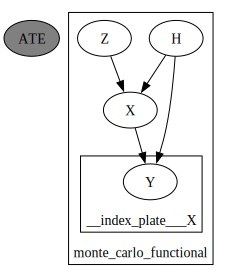

In [3]:
class LinearInstrumentalATE(torch.nn.Module):
    def __init__(self, causal_model : Callable, *, num_monte_carlo : int = 1000):
        super().__init__()
        self.model = causal_model
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(X=(torch.tensor(0.),torch.tensor(1.)))):
                    _, y_all,_ = self.model(*args, **kwargs)
                y_cf_1 = gather(y_all, IndexSet(X={2}), event_dim=0)
                y_cf_0 = gather(y_all, IndexSet(X={1}), event_dim=0)
        
        ate = (y_cf_1 - y_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        return pyro.deterministic("ATE", ate)
        
pyro.render_model(LinearInstrumentalATE(gt_model))

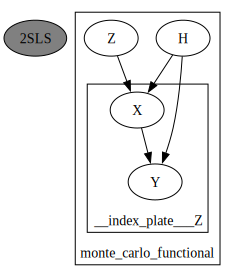

In [4]:
class LinearInstrumentalATE_2SLS(torch.nn.Module):
    def __init__(self, causal_model : Callable, *, num_monte_carlo : int = 1000):
        super().__init__()
        self.model = causal_model
        self.num_monte_carlo = num_monte_carlo

    def forward(self, *args, **kwargs):
        with MultiWorldCounterfactual():
            with pyro.plate("monte_carlo_functional", size=self.num_monte_carlo, dim=-2):
                with do(actions=dict(Z=(torch.tensor(0.),torch.tensor(1.)))):
                    x_all, y_all,_ = self.model(*args, **kwargs)
                y_cf_1 = gather(y_all, IndexSet(Z={2}), event_dim=0)
                y_cf_0 = gather(y_all, IndexSet(Z={1}), event_dim=0)

                x_cf_1 = gather(x_all, IndexSet(Z={2}), event_dim=0)
                x_cf_0 = gather(x_all, IndexSet(Z={1}), event_dim=0)
        
        yz = (y_cf_1 - y_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        xz = (x_cf_1 - x_cf_0).mean(dim=-2, keepdim=True).mean(dim=-1, keepdim=True).squeeze()
        ate_2sls = yz / xz
        return pyro.deterministic("2SLS", ate_2sls)
    
pyro.render_model(LinearInstrumentalATE_2SLS(gt_model))

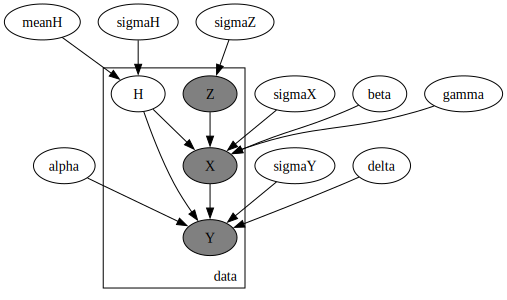

In [5]:
class ObservedBayesianLinearGaussianSCM(BayesianLinearGaussianSCM):
    def __init__(self, n : int):
        super().__init__()
        self.n = n

    def forward(self, X=None, Y=None, Z=None):
        self.alpha, self.beta, self.gamma, self.delta, self.sigmaZ, self.sigmaH, self.sigmaX, self.sigmaY, self.meanH
        with condition(data={'Z': Z, 'X' : X, 'Y': Y}):
            with pyro.plate("data", self.n, dim=-1):
                return super().forward()

pyro.render_model(ObservedBayesianLinearGaussianSCM(10),(torch.tensor([1.0]*10),torch.tensor([1.0]*10),torch.tensor([1.0]*10)))

# Single dataset

## Generate data

In [ ]:
num_samples = 10000

with pyro.plate('samples', num_samples,dim=-1):
    tr=pyro.poutine.trace(gt_model).get_trace()

x_obs,y_obs,z_obs,h_true=[tr.nodes[name]['value'] for name in ['X','Y','Z']]

sns.pairplot(pd.DataFrame({'X':x_obs,'Y':y_obs,'Z':z_obs}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

## ATE Sanity check

sanity check for plug-in estimator

In [ ]:
# sanity check for plug-in estimator
num_mc_samples = 2000
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2), pyro.plate('samples', 1000, dim=-1):
    # x_all,y_all = PredictiveModel(ObservedBayesianLinearGaussianSCM(),obs_guide)(x_obs,y_obs,z_obs)
    x_all,y_all,_=gt_model()

    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2), pyro.plate('samples', 1000, dim=-1):
    x_all,y_all,_=gt_model()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=False, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
# plt.xlim(-3,3)
plt.show()

In [ ]:
LinearInstrumentalATE(gt_model)()

## Inference

In [ ]:
num_iterations = 4000 if not smoke_test else 10

pyro.clear_param_store()

obs_model = ObservedBayesianLinearGaussianSCM(len(x_obs))
obs_guide = AutoNormal(obs_model)
# obs_guide = pyro.infer.autoguide.AutoMultivariateNormal(obs_model)

# svi = SVI(obs_model, obs_guide, pyro.optim.Adam({"lr": 0.01}), loss=Trace_ELBO())
elbo = pyro.infer.Trace_ELBO()(obs_model, obs_guide)

elbo(X=x_obs,Y=y_obs,Z=z_obs)

adam = torch.optim.Adam(elbo.parameters(), lr=0.001)
losses = []
pbar = tqdm(range(num_iterations))
pbar.set_description(f'loss=Inf')
for j in pbar:
    adam.zero_grad()
    loss = elbo(X=x_obs,Y=y_obs,Z=z_obs)
    loss.backward()
    losses.append(loss.item())
    adam.step()
    if (j + 1) % 100 == 0:
        pbar.set_description(f'loss={loss.item()}')
    #     print("[iteration %04d] loss: %.4f" % (j + 1, loss))

# for j in range(num_iterations):
#     # calculate the loss and take a gradient step
#     loss = svi.step(X=x_obs,Y=y_obs,Z=z_obs)
#     if (j + 1) % 1000 == 0:
#         print("[iteration %04d] loss: %.4f" % (j + 1, loss))

# plot loss
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Loss over iterations')
plt.show()

In [ ]:
x_pred,y_pred,z_pred=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()

sns.pairplot(pd.DataFrame({'X':x_pred.detach().numpy(),'Y':y_pred.detach().numpy(),'Z':z_pred.detach().numpy(),}), kind='scatter', markers='.', plot_kws=dict(s=1, edgecolor='b', alpha=0.1, linewidth=1))
plt.show()

In [ ]:
num_mc_samples = 200
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all,_ = PredictiveModel(ObservedBayesianLinearGaussianSCM(len(x_obs)),obs_guide)()
    # x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()

    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all,_ = PredictiveModel(ObservedBayesianLinearGaussianSCM(len(x_obs)),obs_guide)()
    # x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)()

    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
plt.show()

In [ ]:
LinearInstrumentalATE(PredictiveModel(ObservedBayesianLinearGaussianSCM(len(x_obs)), obs_guide), num_monte_carlo=1000)(X=x_obs, Y=y_obs, Z=z_obs)

## One-step correction

In [ ]:
dataset = dict(X=x_obs, Y=y_obs, Z=z_obs)
functional = functools.partial(LinearInstrumentalATE, num_monte_carlo = 100)
ate_plug_in = functional(
    PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)
)()

functional2 = functools.partial(LinearInstrumentalATE, num_monte_carlo = 100)

with MonteCarloInfluenceEstimator(num_samples_outer=10, num_samples_inner=2):
    automated_monte_carlo_correction = one_step_corrected_estimator(functional2, dataset)(
        PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), obs_guide)
    )()

print(f'ATE plug-in: {ate_plug_in}, ATE corrected: {automated_monte_carlo_correction}')

In [ ]:
num_mc_samples = 200
with MultiWorldCounterfactual(), do(actions=dict(X=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    # x_all,y_all = PredictiveModel(ObservedBayesianLinearGaussianSCM(),obs_guide)(x_obs,y_obs,z_obs)
    x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), pyro.poutine.block(hide=['H'])(obs_guide))()

    y_cf_1 = gather(y_all, IndexSet(X={2}))
    y_cf_0 = gather(y_all, IndexSet(X={1}))
    ate = (y_cf_1 - y_cf_0).mean()
    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}')
    print(f'ate_direct={ate}')

# now the two-stage approach
with MultiWorldCounterfactual(), do(actions=dict(Z=(0.,1.))), pyro.plate('monte_carlo_samples', num_mc_samples, dim=-2):
    x_all,y_all,_=PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), pyro.poutine.block(hide=['H'])(obs_guide))()
    y_cf_1 = gather(y_all, IndexSet(Z={2}))
    y_cf_0 = gather(y_all, IndexSet(Z={1}))

    x_cf_1 = gather(x_all, IndexSet(Z={2}))
    x_cf_0 = gather(x_all, IndexSet(Z={1}))

    xz = (x_cf_1 - x_cf_0).mean()
    yz = (y_cf_1 - y_cf_0).mean()

    print(f'Shapes Y: {y_cf_1.shape}, {y_cf_0.shape}, X: {x_cf_1.shape}, {x_cf_0.shape}')

    ate = yz / xz
    print(f'xz = {xz}, yz = {yz}, ate_2sls = {ate}')

# plot the distributions
sns.histplot((y_cf_1-y_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='blue', label='Y-Z')
sns.histplot((x_cf_1-x_cf_0).mean(dim=-1).squeeze().detach().numpy(), bins=20, kde=True, color='red', label='X-Z')
sns.histplot(((y_cf_1-y_cf_0).mean(dim=-1)/(x_cf_1-x_cf_0).mean(dim=-1)).squeeze().detach().numpy(), bins=20, kde=True, color='green', label='ATE')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution:\nTrue XY={true_alpha}, XZ={true_beta}, YZ={true_alpha*true_beta}')
plt.legend()
plt.show()

# Multiple datasets

In [10]:
num_samples = 25000
num_datasets = 10

with pyro.plate("datasets", num_datasets, dim=-2):
    with pyro.plate('samples', num_samples,dim=-1):
        tr=pyro.poutine.trace(gt_model).get_trace()

x_obs_all,y_obs_all,z_obs_all=[tr.nodes[name]['value'] for name in ['X','Y','Z']]

print(x_obs_all.shape,y_obs_all.shape,z_obs_all.shape)

torch.Size([10, 25000]) torch.Size([10, 25000]) torch.Size([10, 25000])


In [11]:
num_elbo_iterations = 2500
verbose = True
pyro.clear_param_store()
# trained_models = []
trained_guides = []
for i in range(num_datasets):
    # Generate data
    x_obs = x_obs_all[i]
    y_obs = y_obs_all[i]
    z_obs = z_obs_all[i]
    
    obs_model = ObservedBayesianLinearGaussianSCM(len(x_obs))
    obs_guide = AutoNormal(obs_model)

    elbo = pyro.infer.Trace_ELBO()(obs_model, obs_guide)
    elbo(X=x_obs,Y=y_obs,Z=z_obs)
    adam = torch.optim.Adam(elbo.parameters(), lr=0.01)
    losses = []
    
    if verbose:
        pbar = tqdm(range(num_elbo_iterations))
        pbar.set_description(f'{i+1}/{num_datasets}: loss=Inf')
    else:
        pbar = range(num_elbo_iterations)

    for j in pbar:
        adam.zero_grad()
        loss = elbo(X=x_obs,Y=y_obs,Z=z_obs)
        loss.backward()
        losses.append(loss.item())
        adam.step()
        if verbose:
            if (j + 1) % 100 == 0:
                pbar.set_description(f'{i+1}/{num_datasets}: loss={loss.item()}')

    trained_guides.append(obs_guide)
    # trained_models.append(obs_model)

1/10: loss=Inf:   0%|          | 0/2500 [00:00<?, ?it/s]

10/10: loss=-31934.83203125: 100%|██████████| 2500/2500 [00:16<00:00, 147.13it/s] 


Calculating ATEs:   0%|          | 0/10 [00:00<?, ?it/s]/Users/dima/git/chirho/chirho/robust/handlers/estimators.py:72: UserWarning: Calling influence_fn with torch.grad enabled can lead to memory leaks. Please use torch.no_grad() to avoid this issue. See example in the docstring.
  warnings.warn(
Dataset 10: ATE plug-in: 1.4287691116333008, ATE corrected: tensor([1.4287], grad_fn=<AddBackward0>): 100%|██████████| 10/10 [02:16<00:00, 13.65s/it]


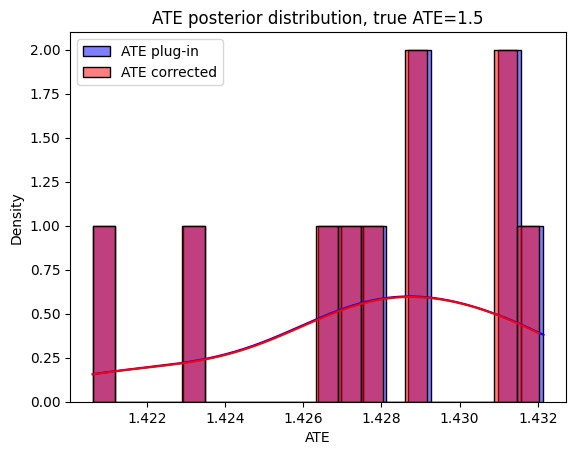

In [12]:
do_one_step_correction = True
num_mc_iterations = 1000

ate_plug_ins = []
ate_correcteds = []

pbar = tqdm(range(num_datasets))
pbar.set_description('Calculating ATEs')

for i in pbar:
    dataset = dict(X=x_obs_all[i], Y=y_obs_all[i], Z=z_obs_all[i])
    predictive = PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), trained_guides[i])
    functional = functools.partial(LinearInstrumentalATE, num_monte_carlo = num_mc_iterations)
    ate_plug_in = functional(
        predictive
    )()

    if do_one_step_correction:
        with MonteCarloInfluenceEstimator(num_samples_outer=10, num_samples_inner=1):
            automated_monte_carlo_correction = one_step_corrected_estimator(functional, dataset)(
                predictive
            )()
        ate_correcteds.append(automated_monte_carlo_correction.item())
    else:
        automated_monte_carlo_correction = None

    pbar.set_description(f'Dataset {i+1}: ATE plug-in: {ate_plug_in}, ATE corrected: {automated_monte_carlo_correction}')

    ate_plug_ins.append(ate_plug_in.item())

# distribution plot
sns.histplot(ate_plug_ins, bins=20, kde=True, color='blue', label='ATE plug-in')
sns.histplot(ate_correcteds, bins=20, kde=True, color='red', label='ATE corrected')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'ATE posterior distribution, true ATE={true_alpha}')
plt.legend()
plt.show()

Calculating 2SLSs:   0%|          | 0/10 [00:00<?, ?it/s]/Users/dima/git/chirho/chirho/robust/handlers/estimators.py:72: UserWarning: Calling influence_fn with torch.grad enabled can lead to memory leaks. Please use torch.no_grad() to avoid this issue. See example in the docstring.
  warnings.warn(
Dataset 10: 2SLS plug-in: 1.4287163019180298, 2SLS corrected: tensor([1.4287], grad_fn=<AddBackward0>): 100%|██████████| 10/10 [02:41<00:00, 16.12s/it]


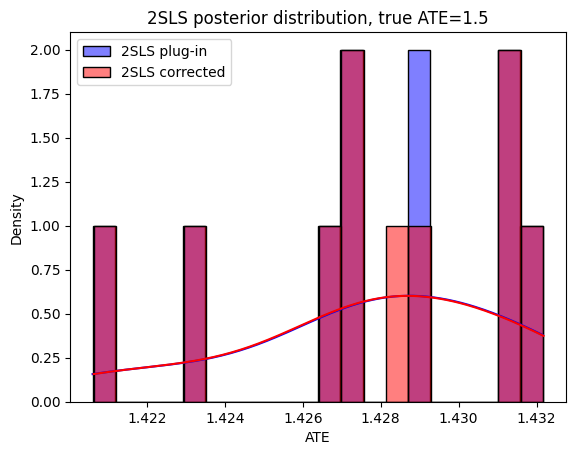

In [13]:
do_one_step_correction = True
num_mc_iterations = 1000

two_sls_plug_ins = []
two_sls_correcteds = []

pbar = tqdm(range(num_datasets))
pbar.set_description('Calculating 2SLSs')

for i in pbar:
    dataset = dict(X=x_obs_all[i], Y=y_obs_all[i], Z=z_obs_all[i])
    predictive = PredictiveModel(pyro.plate('data',len(x_obs), dim=-1)(BayesianLinearGaussianSCM()), trained_guides[i])
    functional = functools.partial(LinearInstrumentalATE_2SLS, num_monte_carlo = num_mc_iterations)
    two_sls_plug_in = functional(
        predictive
    )()

    if do_one_step_correction:
        with MonteCarloInfluenceEstimator(num_samples_outer=10, num_samples_inner=1):
            automated_monte_carlo_correction = one_step_corrected_estimator(functional, dataset)(
                predictive
            )()
        two_sls_correcteds.append(automated_monte_carlo_correction.item())
    else:
        automated_monte_carlo_correction = None

    pbar.set_description(f'Dataset {i+1}: 2SLS plug-in: {two_sls_plug_in}, 2SLS corrected: {automated_monte_carlo_correction}')

    two_sls_plug_ins.append(two_sls_plug_in.item())

# distribution plot
sns.histplot(two_sls_plug_ins, bins=20, kde=True, color='blue', label='2SLS plug-in')
sns.histplot(two_sls_correcteds, bins=20, kde=True, color='red', label='2SLS corrected')
plt.xlabel('ATE')
plt.ylabel('Density')
plt.title(f'2SLS posterior distribution, true ATE={true_alpha}')
plt.legend()
plt.show()